In [102]:
from pickletools import optimize
from statistics import mode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

import tushare as ts
import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

stock_code = '600519.SH'

features = ['open', 'high', 'low', 'close', 'vol', 'amount']

ts.set_token('51fd5a77415e6299ad8243e387472a5552e3d24f5c889781caef6d89')
data = ts.pro_bar(ts_code=stock_code, adj='qfq', start_date='20120101', end_date='20211231')
data['date'] = pd.to_datetime(data['trade_date'], format = "%Y/%m/%d %H:%M:%S")
data.set_index('date', inplace=True)  # 设置索引覆盖原来的数据
data = data.sort_index(ascending=True)  # 将时间顺序升序，符合时间序列
#data = data[['high', 'low', 'open', 'close', 'vol']]
print(data)
# ['ts_code', 'open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount']
"""
company = 'FB'

start = dt.datetime(2019, 1, 1)
end = dt.datetime(2019, 1, 5)
data = web.DataReader(company, 'yahoo', start, end)

print(list(data))
"""
"""
                  High         Low        Open       Close    Volume   Adj Close
Date                                                                            
2021-09-17  371.410004  361.589996  371.410004  364.720001  26299000  364.720001
2021-09-20  361.029999  349.799988  359.299988  355.700012  19822800  355.700012
2021-09-21  360.040009  355.190002  358.500000  357.480011  11751900  357.480011
"""

              ts_code trade_date       open       high        low      close  \
date                                                                           
2012-01-04  600519.SH   20120104   132.3641   133.2419   127.8713   128.0579   
2012-01-05  600519.SH   20120105   127.1801   128.0095   126.0465   126.5926   
2012-01-06  600519.SH   20120106   126.5580   129.9794   125.5558   129.0048   
2012-01-09  600519.SH   20120109   128.5625   130.0071   125.6387   129.9518   
2012-01-10  600519.SH   20120110   129.2537   134.5482   128.6385   134.4238   
...               ...        ...        ...        ...        ...        ...   
2021-12-27  600519.SH   20211227  2168.0000  2168.0000  2112.0000  2131.8200   
2021-12-28  600519.SH   20211228  2133.0000  2155.5000  2116.6000  2138.1800   
2021-12-29  600519.SH   20211229  2150.0000  2154.2500  2041.0000  2041.0000   
2021-12-30  600519.SH   20211230  2041.0000  2088.9800  2028.0000  2075.0000   
2021-12-31  600519.SH   20211231  2070.0

'\n                  High         Low        Open       Close    Volume   Adj Close\nDate                                                                            \n2021-09-17  371.410004  361.589996  371.410004  364.720001  26299000  364.720001\n2021-09-20  361.029999  349.799988  359.299988  355.700012  19822800  355.700012\n2021-09-21  360.040009  355.190002  358.500000  357.480011  11751900  357.480011\n'

In [103]:
# prepare data
# scale down the 
scaler = MinMaxScaler(feature_range=(0,1))
raw_data = data[features]

before_scale = raw_data.values.reshape(-1, len(features))

scaled_data = scaler.fit_transform(before_scale)

prediction_days = 5
#print(scaled_data)
#print('------')

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days: x, :])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

print(x_train)

[[[0.0186442  0.01825334 0.01780538 0.01684431 0.09156707 0.02162254]
  [0.01655182 0.01617365 0.01703742 0.01625596 0.07820141 0.0179964 ]
  [0.01630073 0.01695661 0.01683091 0.01722451 0.06064923 0.01416218]
  [0.01710979 0.01696762 0.0168658  0.01760475 0.06409965 0.01496772]
  [0.01738877 0.01877255 0.01812826 0.01940035 0.11063281 0.02646529]]

 [[0.01655182 0.01617365 0.01703742 0.01625596 0.07820141 0.0179964 ]
  [0.01630073 0.01695661 0.01683091 0.01722451 0.06064923 0.01416218]
  [0.01710979 0.01696762 0.0168658  0.01760475 0.06409965 0.01496772]
  [0.01738877 0.01877255 0.01812826 0.01940035 0.11063281 0.02646529]
  [0.01904871 0.01856102 0.01905618 0.01806822 0.11296583 0.02697989]]

 [[0.01630073 0.01695661 0.01683091 0.01722451 0.06064923 0.01416218]
  [0.01710979 0.01696762 0.0168658  0.01760475 0.06409965 0.01496772]
  [0.01738877 0.01877255 0.01812826 0.01940035 0.11063281 0.02646529]
  [0.01904871 0.01856102 0.01905618 0.01806822 0.11296583 0.02697989]
  [0.01782957 0.

In [104]:
# build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], len(features))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
76/76 [==============================] - 5s 7ms/step - loss: 0.0157
Epoch 2/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 3/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 4/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 5/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 6/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 7/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 8/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 9/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 10/25
76/76 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 11/25
76/76 [==============================] - 0s 6ms/step - loss: 9.8928e-04
Epoch 12/25
76/76 [==============================] - 0s 6ms/step - loss: 9.0705e-04
Epoch 13/25
76/76 [======================

In [105]:
test_data = ts.pro_bar(ts_code=stock_code, adj='qfq', start_date='20220101')
test_data['date'] = pd.to_datetime(test_data['trade_date'], format = "%Y/%m/%d %H:%M:%S")
test_data.set_index('date', inplace=True)  # 设置索引覆盖原来的数据
test_data = test_data.sort_index(ascending=True)  # 将时间顺序升序，符合时间序列
#test_data = test_data[['high', 'low', 'open', 'close', 'vol']]
actual_prices = test_data['close']

In [106]:
def inverse_predictions(predictions,scaler,prediction_index=2):
    '''This function uses the fitted scaler to inverse predictions, 
    the index should be set to the position of the target variable'''
    
    max_val = scaler.data_max_[prediction_index]
    min_val = scaler.data_min_[prediction_index]
    original_values = (predictions*(max_val - min_val )) + min_val
    
    return original_values

In [107]:
total_dataset = pd.concat((raw_data, test_data[features]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, len(features))
model_inputs = scaler.transform(model_inputs)

x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

predicted_prices = model.predict(x_test)
print(predicted_prices.shape)
#predicted_prices = predicted_prices.reshape(-1, 1)
#predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices = inverse_predictions(predicted_prices, scaler, 0)
print(predicted_prices)
print(type(predicted_prices))
actual_prices = test_data['close']
print(actual_prices.values)
print(type(actual_prices.values))

6/6 [==============================] - 1s 3ms/step
(172, 1)
[[2038.118 ]
 [2019.0135]
 [1994.8309]
 [1980.7015]
 [1963.98  ]
 [1941.0787]
 [1920.8273]
 [1899.6837]
 [1891.5776]
 [1882.8745]
 [1870.2983]
 [1852.5718]
 [1830.9358]
 [1830.9435]
 [1843.7828]
 [1865.3511]
 [1884.1832]
 [1895.5236]
 [1898.5353]
 [1893.2147]
 [1886.6514]
 [1874.5062]
 [1855.3208]
 [1827.8286]
 [1815.3239]
 [1812.0671]
 [1821.9822]
 [1824.3301]
 [1824.5168]
 [1832.7697]
 [1841.6018]
 [1840.7556]
 [1829.4926]
 [1810.8915]
 [1786.3628]
 [1758.4618]
 [1751.6626]
 [1747.6981]
 [1763.3063]
 [1770.8353]
 [1772.7192]
 [1757.8894]
 [1733.5531]
 [1716.706 ]
 [1712.4591]
 [1720.499 ]
 [1713.7006]
 [1692.9246]
 [1654.492 ]
 [1632.1235]
 [1624.4601]
 [1652.2529]
 [1677.0997]
 [1680.0449]
 [1681.4874]
 [1677.795 ]
 [1670.0837]
 [1658.9731]
 [1647.3318]
 [1648.4546]
 [1678.2112]
 [1699.1995]
 [1714.0756]
 [1724.6403]
 [1726.5146]
 [1723.7823]
 [1722.6528]
 [1722.2906]
 [1738.0781]
 [1751.0417]
 [1758.5559]
 [1757.273 ]
 [17

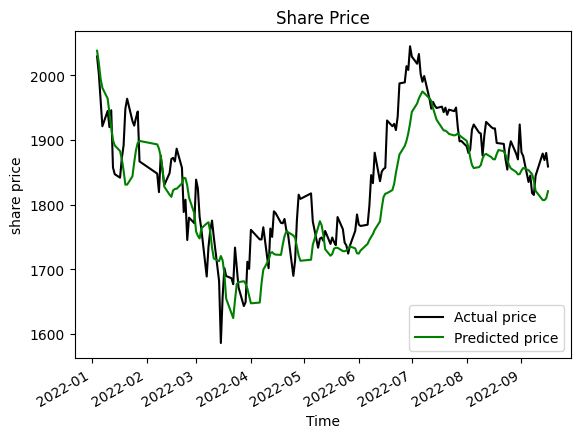

In [108]:
# create a dataframe and use the index from another dataframe
predicted_prices = pd.DataFrame(predicted_prices, index = actual_prices.index)
plt.plot(actual_prices, color='black', label=f'Actual price')
plt.plot(predicted_prices, color='green', label='Predicted price')
plt.title('Share Price')
plt.xlabel('Time')
plt.ylabel('share price')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()